In [1]:
from datetime import datetime
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset

# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [2]:
train, valid, test = load_dataset(creator=ECG200(),
                                  data_path=Path(api_dir) / "src/datasets/ECG200")

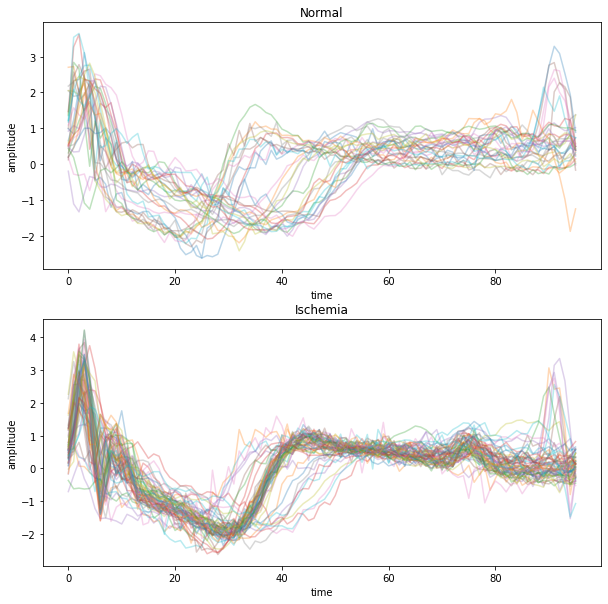

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays. This can be done manually or using the helper function found in the dataset_creator module.

In [6]:
from src.utils.dataset_creator import data_array_to_numpy
train_numpy, valid_numpy, test_numpy = data_array_to_numpy(train, valid, test)

# Classify heartbeats
To be able to classify the heartbeats a model needs created and to be fitted
## Create model

In [7]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

In [8]:
# define and fit classifier
output_dir = Path(api_dir) / "src/output"/ datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=output_dir, **hp_dict)

## Fitting model
To fit the model to the training set the `.fit_classifier` method is used.

In [9]:
clf.fit_classifier(train_numpy, test_numpy)

Epoch 1/500
6/6 [==============================] - 3s 573ms/step - loss: 0.7039 - tp: 50.0000 - fp: 40.0000 - tn: 50.0000 - fn: 40.0000 - accuracy: 0.5556 - precision: 0.5556 - recall: 0.5556 - auc: 0.6030 - prc: 0.6108 - val_loss: 0.6883 - val_tp: 75.0000 - val_fp: 25.0000 - val_tn: 75.0000 - val_fn: 25.0000 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.7449 - val_prc: 0.7084
Epoch 2/500
6/6 [==============================] - 0s 57ms/step - loss: 0.6860 - tp: 75.0000 - fp: 15.0000 - tn: 75.0000 - fn: 15.0000 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.8039 - prc: 0.7797 - val_loss: 0.6904 - val_tp: 42.0000 - val_fp: 58.0000 - val_tn: 42.0000 - val_fn: 58.0000 - val_accuracy: 0.4200 - val_precision: 0.4200 - val_recall: 0.4200 - val_auc: 0.5291 - val_prc: 0.5642
Epoch 3/500
6/6 [==============================] - 0s 50ms/step - loss: 0.6896 - tp: 50.0000 - fp: 40.0000 - tn: 50.0000 - fn: 40.0000 - accuracy: 0.5556 - precision: 0.55

Epoch 21/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3271 - tp: 71.0000 - fp: 19.0000 - tn: 71.0000 - fn: 19.0000 - accuracy: 0.7889 - precision: 0.7889 - recall: 0.7889 - auc: 0.9121 - prc: 0.9185 - val_loss: 0.4037 - val_tp: 82.0000 - val_fp: 18.0000 - val_tn: 82.0000 - val_fn: 18.0000 - val_accuracy: 0.8200 - val_precision: 0.8200 - val_recall: 0.8200 - val_auc: 0.9004 - val_prc: 0.8907
Epoch 22/500
6/6 [==============================] - 0s 66ms/step - loss: 0.2974 - tp: 81.0000 - fp: 9.0000 - tn: 81.0000 - fn: 9.0000 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9577 - prc: 0.9602 - val_loss: 0.4038 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9018 - val_prc: 0.9024
Epoch 23/500
6/6 [==============================] - 0s 43ms/step - loss: 0.2671 - tp: 77.0000 - fp: 13.0000 - tn: 77.0000 - fn: 13.0000 - accuracy: 0.8556 - precision: 0.85

Epoch 41/500
6/6 [==============================] - 0s 50ms/step - loss: 0.1715 - tp: 82.0000 - fp: 8.0000 - tn: 82.0000 - fn: 8.0000 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9765 - prc: 0.9778 - val_loss: 0.4168 - val_tp: 84.0000 - val_fp: 16.0000 - val_tn: 84.0000 - val_fn: 16.0000 - val_accuracy: 0.8400 - val_precision: 0.8400 - val_recall: 0.8400 - val_auc: 0.9200 - val_prc: 0.9094
Epoch 42/500
6/6 [==============================] - 0s 54ms/step - loss: 0.1557 - tp: 84.0000 - fp: 6.0000 - tn: 84.0000 - fn: 6.0000 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9915 - prc: 0.9918 - val_loss: 0.4046 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9279 - val_prc: 0.9235
Epoch 43/500
6/6 [==============================] - 0s 55ms/step - loss: 0.1443 - tp: 83.0000 - fp: 7.0000 - tn: 83.0000 - fn: 7.0000 - accuracy: 0.9222 - precision: 0.9222 -

Epoch 61/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1001 - tp: 86.0000 - fp: 4.0000 - tn: 86.0000 - fn: 4.0000 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9965 - prc: 0.9966 - val_loss: 0.4702 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9261 - val_prc: 0.9141
Epoch 62/500
6/6 [==============================] - 0s 48ms/step - loss: 0.0894 - tp: 87.0000 - fp: 3.0000 - tn: 87.0000 - fn: 3.0000 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9965 - prc: 0.9966 - val_loss: 0.4825 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9253 - val_prc: 0.9142
Epoch 63/500
6/6 [==============================] - 0s 52ms/step - loss: 0.0778 - tp: 86.0000 - fp: 4.0000 - tn: 86.0000 - fn: 4.0000 - accuracy: 0.9556 - precision: 0.9556 -

Epoch 81/500
6/6 [==============================] - 0s 53ms/step - loss: 0.0509 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9996 - prc: 0.9996 - val_loss: 0.5408 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9318 - val_prc: 0.9214
Epoch 82/500
6/6 [==============================] - 0s 45ms/step - loss: 0.0556 - tp: 86.0000 - fp: 4.0000 - tn: 86.0000 - fn: 4.0000 - accuracy: 0.9556 - precision: 0.9556 - recall: 0.9556 - auc: 0.9980 - prc: 0.9981 - val_loss: 0.6425 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9252 - val_prc: 0.9165
Epoch 83/500
6/6 [==============================] - 0s 55ms/step - loss: 0.0454 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 

Epoch 101/500
6/6 [==============================] - 0s 49ms/step - loss: 0.0284 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9996 - prc: 0.9996 - val_loss: 0.7310 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9131 - val_prc: 0.8971
Epoch 102/500
6/6 [==============================] - 0s 60ms/step - loss: 0.0264 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.6565 - val_tp: 85.0000 - val_fp: 15.0000 - val_tn: 85.0000 - val_fn: 15.0000 - val_accuracy: 0.8500 - val_precision: 0.8500 - val_recall: 0.8500 - val_auc: 0.9323 - val_prc: 0.9233
Epoch 103/500
6/6 [==============================] - 0s 42ms/step - loss: 0.0292 - tp: 89.0000 - fp: 1.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.9889 - precisio

6/6 [==============================] - 0s 49ms/step - loss: 0.0111 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7947 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9158 - val_prc: 0.9003
Epoch 121/500
6/6 [==============================] - 0s 50ms/step - loss: 0.0117 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7056 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9342 - val_prc: 0.9254
Epoch 122/500
6/6 [==============================] - 0s 48ms/step - loss: 0.0093 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 64ms/step - loss: 0.0028 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8339 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9253 - val_prc: 0.9131
Epoch 140/500
6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8211 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9267 - val_prc: 0.9146
Epoch 141/500
6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 59ms/step - loss: 0.0017 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8882 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9114 - val_prc: 0.8931
Epoch 159/500
6/6 [==============================] - 0s 50ms/step - loss: 0.0023 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8637 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9273 - val_prc: 0.9153
Epoch 160/500
6/6 [==============================] - 0s 49ms/step - loss: 0.0020 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 58ms/step - loss: 0.0011 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9139 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9122 - val_prc: 0.8941
Epoch 178/500
6/6 [==============================] - 0s 51ms/step - loss: 0.0012 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9140 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9198 - val_prc: 0.9047
Epoch 179/500
6/6 [==============================] - 0s 52ms/step - loss: 0.0012 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precis

6/6 [==============================] - 0s 50ms/step - loss: 8.4325e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9385 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9132 - val_prc: 0.8953
Epoch 197/500
6/6 [==============================] - 0s 57ms/step - loss: 8.1519e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9408 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9140 - val_prc: 0.8963
Epoch 198/500
6/6 [==============================] - 0s 64ms/step - loss: 7.9650e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 59ms/step - loss: 6.0646e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9652 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9140 - val_prc: 0.8963
Epoch 216/500
6/6 [==============================] - 0s 48ms/step - loss: 6.0702e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9677 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9139 - val_prc: 0.8962
Epoch 217/500
6/6 [==============================] - 0s 55ms/step - loss: 6.0373e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 48ms/step - loss: 4.9149e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0154 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9060 - val_prc: 0.8856
Epoch 235/500
6/6 [==============================] - 0s 50ms/step - loss: 5.0086e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0005 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9063 - val_prc: 0.8859
Epoch 236/500
6/6 [==============================] - 0s 59ms/step - loss: 4.5474e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 61ms/step - loss: 3.8764e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0047 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9067 - val_prc: 0.8862
Epoch 254/500
6/6 [==============================] - 0s 48ms/step - loss: 4.0927e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0291 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9058 - val_prc: 0.8855
Epoch 255/500
6/6 [==============================] - 0s 62ms/step - loss: 3.7261e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 45ms/step - loss: 3.1195e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0340 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9066 - val_prc: 0.8862
Epoch 273/500
6/6 [==============================] - 0s 49ms/step - loss: 3.3086e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0268 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9067 - val_prc: 0.8862
Epoch 274/500
6/6 [==============================] - 0s 48ms/step - loss: 3.4561e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 51ms/step - loss: 2.7279e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0499 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8988 - val_prc: 0.8759
Epoch 292/500
6/6 [==============================] - 0s 68ms/step - loss: 2.7477e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0703 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.9059 - val_prc: 0.8855
Epoch 293/500
6/6 [==============================] - 1s 94ms/step - loss: 2.5267e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 80ms/step - loss: 2.1211e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0683 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8988 - val_prc: 0.8759
Epoch 311/500
6/6 [==============================] - 1s 88ms/step - loss: 2.1163e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0634 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9076 - val_prc: 0.8874
Epoch 312/500
6/6 [==============================] - 0s 79ms/step - loss: 2.0800e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 50ms/step - loss: 1.7886e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0800 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8998 - val_prc: 0.8771
Epoch 330/500
6/6 [==============================] - 0s 55ms/step - loss: 1.7810e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0871 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8993 - val_prc: 0.8767
Epoch 331/500
6/6 [==============================] - 0s 46ms/step - loss: 1.7633e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 48ms/step - loss: 1.5289e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0908 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8998 - val_prc: 0.8771
Epoch 349/500
6/6 [==============================] - 0s 58ms/step - loss: 1.4844e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1000 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8995 - val_prc: 0.8768
Epoch 350/500
6/6 [==============================] - 0s 40ms/step - loss: 1.5120e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 50ms/step - loss: 1.3693e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0972 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9008 - val_prc: 0.8783
Epoch 368/500
6/6 [==============================] - 0s 60ms/step - loss: 1.3043e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1146 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8996 - val_prc: 0.8769
Epoch 369/500
6/6 [==============================] - 0s 50ms/step - loss: 1.3086e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 48ms/step - loss: 1.1760e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1206 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8998 - val_prc: 0.8771
Epoch 387/500
6/6 [==============================] - 0s 45ms/step - loss: 1.2119e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1101 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.9009 - val_prc: 0.8784
Epoch 388/500
6/6 [==============================] - 0s 59ms/step - loss: 1.1758e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 49ms/step - loss: 1.0977e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1265 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8999 - val_prc: 0.8771
Epoch 406/500
6/6 [==============================] - 0s 39ms/step - loss: 1.1025e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1308 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8997 - val_prc: 0.8770
Epoch 407/500
6/6 [==============================] - 0s 57ms/step - loss: 1.0943e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 49ms/step - loss: 1.0471e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1353 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8917 - val_prc: 0.8668
Epoch 425/500
6/6 [==============================] - 0s 59ms/step - loss: 1.0161e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1337 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8920 - val_prc: 0.8670
Epoch 426/500
6/6 [==============================] - 0s 58ms/step - loss: 1.0117e-04 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 50ms/step - loss: 9.7868e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1333 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8928 - val_prc: 0.8681
Epoch 444/500
6/6 [==============================] - 0s 56ms/step - loss: 9.7780e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1317 - val_tp: 86.0000 - val_fp: 14.0000 - val_tn: 86.0000 - val_fn: 14.0000 - val_accuracy: 0.8600 - val_precision: 0.8600 - val_recall: 0.8600 - val_auc: 0.8928 - val_prc: 0.8681
Epoch 445/500
6/6 [==============================] - 0s 50ms/step - loss: 9.7701e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 2s 324ms/step - loss: 9.4809e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1389 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8920 - val_prc: 0.8670
Epoch 463/500
6/6 [==============================] - 0s 43ms/step - loss: 9.3964e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1381 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8920 - val_prc: 0.8670
Epoch 464/500
6/6 [==============================] - 0s 38ms/step - loss: 9.4306e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.

6/6 [==============================] - 0s 66ms/step - loss: 9.1343e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1405 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8929 - val_prc: 0.8682
Epoch 482/500
6/6 [==============================] - 0s 51ms/step - loss: 9.1148e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1432 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8919 - val_prc: 0.8669
Epoch 483/500
6/6 [==============================] - 0s 32ms/step - loss: 9.1326e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0

6/6 [==============================] - 0s 54ms/step - loss: 8.9365e-05 - tp: 90.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.1426 - val_tp: 87.0000 - val_fp: 13.0000 - val_tn: 87.0000 - val_fn: 13.0000 - val_accuracy: 0.8700 - val_precision: 0.8700 - val_recall: 0.8700 - val_auc: 0.8929 - val_prc: 0.8682


## Classification and evaluation
After training the network its possible to use the model on new data.
To apply the model on some data the `model.predict` method is used.
It is also possible to evaluate model performance using `model.evaluate`.

In [10]:
# make classification
y_pred = clf.model.predict(x=test_numpy.X)

In [11]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 7ms/step - loss: 1.1426 - tp: 87.0000 - fp: 13.0000 - tn: 87.0000 - fn: 13.0000 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.8929 - prc: 0.8682


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.142582,87.0,13.0,87.0,13.0,0.87,0.87,0.87,0.8929,0.868188


# Explain classification
It might also be of interest, to get insight on what the network based its classification on.
Here we can use an explainer such as the SHAP gradient explainer.

In [12]:
is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

Using TensorFlow backend.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
The overlay color is determined by the shap value.

In [13]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])

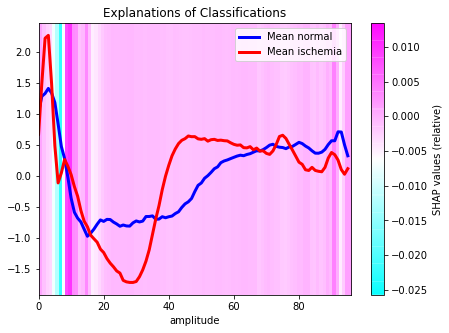

In [14]:
plot_importance(X_to_explain = test_numpy.X, y_pred = y_pred, explanation = ex_classification)